In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

import warnings
%matplotlib inline

In [2]:
# Loading the Santander Customer satisfaction dataset from Kaggle
data=pd.read_csv('datasets/santander.csv')
data.shape

(76020, 371)

In [3]:
# Separate dataset into train and test
x_train,x_test,y_train,y_test=train_test_split(data.drop(labels=['TARGET'],axis=1),
                                              data['TARGET'],test_size=0.3,random_state=0)
x_train.shape,x_test.shape

((53214, 370), (22806, 370))

In [4]:
# Saving the copy of the df to test on Models for acuracy
x_train_original=x_train.copy()
x_test_original=x_test.copy()

In [5]:
# Creating a list of all constant features with 0 STD DEV.
constant_features=[feat for feat in x_train.columns if x_train[feat].std()==0]

# Exploring constant feature
data['ind_var2_0'].unique()

array([0])

In [6]:
# Removing all the constant features columns from the df
x_train.drop(labels=constant_features,axis=1,inplace=True)
x_test.drop(labels=constant_features,axis=1,inplace=True)

In [7]:
#  Successfully removed almost 38 constant features
x_train.shape,x_test.shape

((53214, 332), (22806, 332))

### Removing quasi-static features with 99% observation appr data

In [8]:
sel=VarianceThreshold(threshold=0.01)
sel.fit(x_train)

#how many not quasi-constant
sum(sel.get_support())

268

In [9]:
# Total quasi-constant features
t=list(sel.get_support())
t.count(0)

64

In [10]:
# keep the list of features to keep
features_to_keep=x_train.columns[sel.get_support()]

In [11]:
# We can remove this feature from the df 
# We have removed a total of 70 features so far
x_train=sel.transform(x_train)
x_test=sel.transform(x_test)
x_train.shape,x_test.shape

((53214, 268), (22806, 268))

In [12]:
# sklearn transformation leads to np array 
type(x_train)

numpy.ndarray

In [13]:
# Converting back to df
x_train=pd.DataFrame(x_train,columns=features_to_keep)
x_test=pd.DataFrame(x_test,columns=features_to_keep)

x_train.shape,x_test.shape

((53214, 268), (22806, 268))

### Removing all the duplicate features from the DF

In [14]:
# Check for the duplicate features
duplicated_feat=[]
# Can use set as well inplace of list for removing redundant columns
  
for i in range(len(x_train.columns)):
    # To know code is running
    if i%10==0:
        print(i)
        
    col1=x_train.columns[i]
    for col2 in x_train.columns[i+1:]:
        if x_train[col1].equals(x_train[col2]):
            duplicated_feat.append(col2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


16

In [15]:
# Removing all the duplicate features
x_train.drop(labels=duplicated_feat,axis=1,inplace=True)
x_test.drop(labels=duplicated_feat,axis=1,inplace=True)

# Successfully removed 16 duplicated features
# Intotal we have removed almost 118 features 
x_train.shape,x_test.shape

((53214, 252), (22806, 252))

In [16]:
# Keep the copy of df except constant and duplicated features to measure the performance at the end
x_train_basic_filter=x_train.copy()
x_test_basic_filter=x_test.copy()

## Removing all the Correlated features

<font size=4> Visualising Correlation

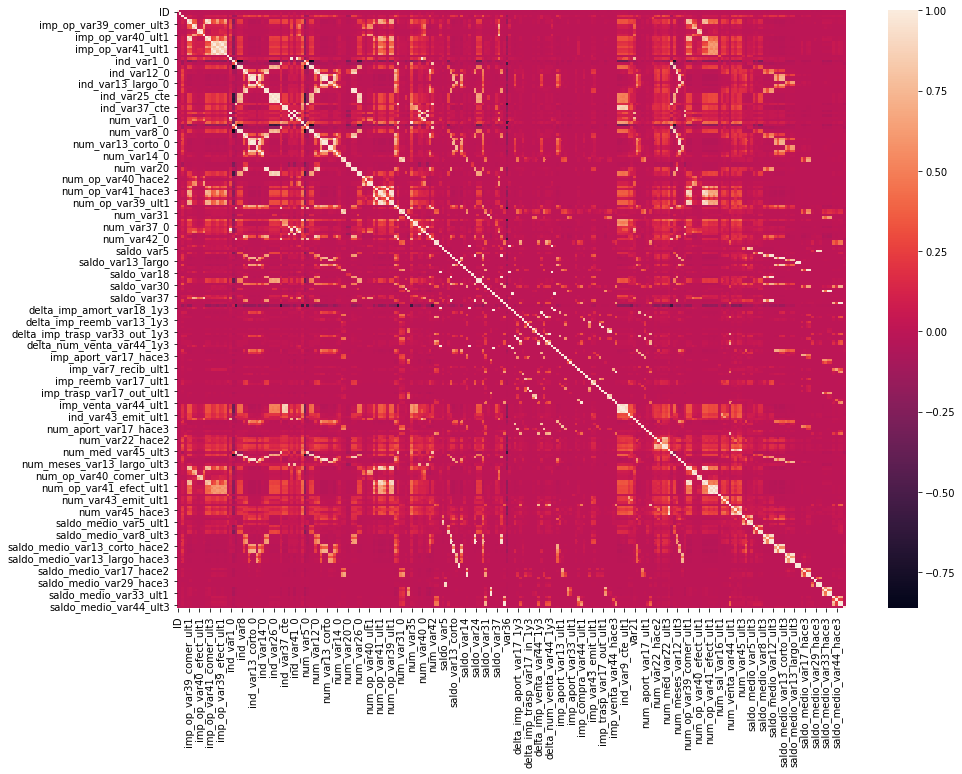

In [17]:
# creating correlation
corr_matrix=x_train.corr()

fig,ax=plt.subplots()
fig.set_size_inches(15,11)
sns.heatmap(corr_matrix)

In [18]:
corr_matrix.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
ID,1.000000,-0.002694,-0.001429,-0.004771,0.003904,0.001377,-0.004445,-0.004665,-0.007750,-0.006784,...,-0.009078,0.007105,0.007444,0.003968,0.004385,-0.003306,0.000275,-0.000197,0.001404,-0.002467
var3,-0.002694,1.000000,-0.003769,0.001790,0.005309,0.006322,0.001540,0.001697,0.000536,0.000632,...,0.000280,0.000738,0.000553,0.000732,0.000770,0.000642,0.000465,0.000769,0.000805,0.000140
var15,-0.001429,-0.003769,1.000000,0.042432,0.095696,0.101386,0.042572,0.045842,0.008120,0.009172,...,0.013782,0.027528,0.018402,0.028426,0.029238,0.031925,0.019212,0.034742,0.034995,0.004416
imp_ent_var16_ult1,-0.004771,0.001790,0.042432,1.000000,0.042590,0.035779,0.013211,0.012599,-0.000342,0.000678,...,0.008953,-0.000910,-0.000684,-0.000888,-0.000931,0.003087,-0.000595,0.006117,0.008007,-0.000348
imp_op_var39_comer_ult1,0.003904,0.005309,0.095696,0.042590,1.000000,0.889181,0.353187,0.304416,0.029921,0.051720,...,0.001317,0.023219,0.019279,0.018805,0.020868,0.010844,0.008638,0.013411,0.012702,0.009369


In [19]:
# find and remove correlated Features
def correlation(dataset,threshold):
    col_corr=set()    # Set of all the names of correlated columns
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]    # Getting the name of the columns
                col_corr.add(colname)
    return col_corr

In [20]:
corr_features=correlation(x_train,0.8)

# Printing the size of the correlated features
# For in-depth Correlation study use the second approach in Correlation_FE.ipynb
print('Correlated Features : {}'.format(len(set(corr_features))))

Correlated Features : 133


In [21]:
# Removing all the correlated features
x_train.drop(labels=corr_features,inplace=True,axis=1)
x_test.drop(labels=corr_features,inplace=True,axis=1)

# Size of the training and the testing set after removing Correlated Features
# Hence, we have removed total of 251 features
x_train.shape,x_test.shape

((53214, 119), (22806, 119))

## Remove features using univariate roc_auc

In [22]:
# find important features using univariate roc-auc
# loop to build the tree, make predictions and get the roc-auc
# for each feature of the train set

# removing Future warnings
warnings.filterwarnings('ignore')

roc_values=[]

for feature in x_train.columns:
    clf=RandomForestClassifier().fit(x_train[feature].fillna(0).to_frame(),y_train)
    y_scored=clf.predict_proba(x_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test,y_scored[:,1]))

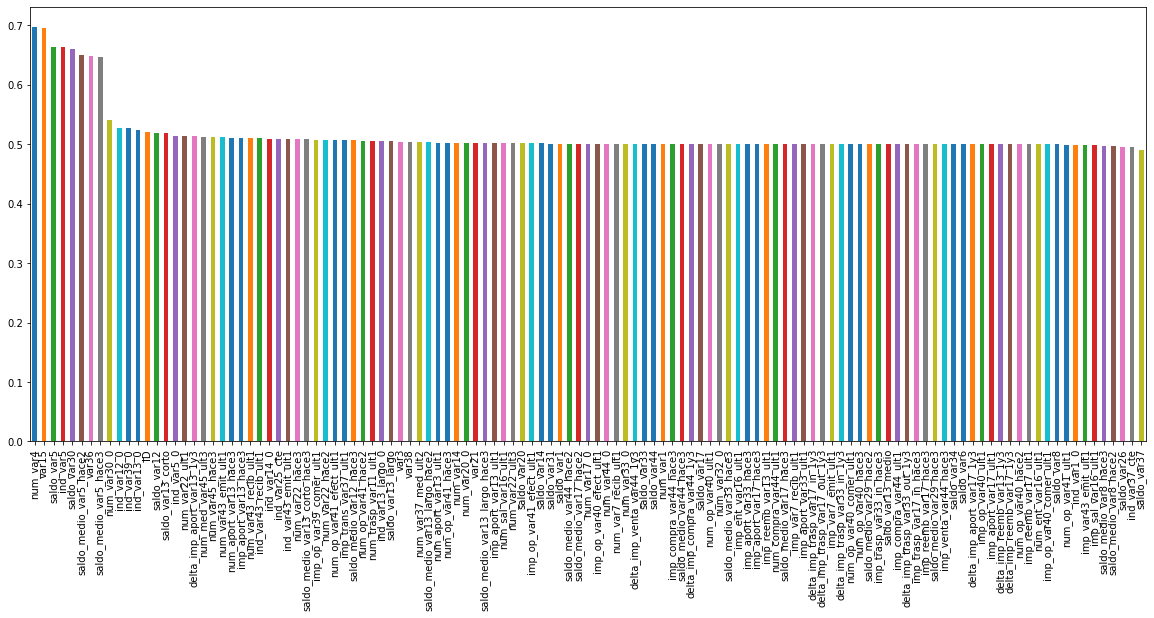

In [23]:
# Let's add variable name against the roc_auc values
roc_values=pd.Series(roc_values)
roc_values.index=x_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [25]:
# Remove roc_auc values less than 0.5
# as it corresponds to random guess or worst.

selected_feat=roc_values[roc_values>0.5]
len(selected_feat),x_train.shape[1]

(93, 119)

In [27]:
selected_feat.head()

ID                         0.519586
var3                       0.504090
var15                      0.695986
imp_ent_var16_ult1         0.500181
imp_op_var39_comer_ult1    0.507725
dtype: float64

<p>
<font size=5> Compare Performance in ML models</font>

### A. Random Forest

In [28]:
# Create a function to build random forests and compare performance in train and test sets
def run_randomforest(x_train,x_test,y_train,y_test):
    rf=RandomForestClassifier(n_estimators=200,max_depth=4,random_state=39)
    rf.fit(x_train,y_train)
    print('Train set')
    pred=rf.predict_proba(x_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train,pred[:,1])))
    print('Test set')
    pred=rf.predict_proba(x_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test,pred[:,1])))

In [29]:
# Calling the function with original data with 370 features
run_randomforest(x_train_original.drop(labels=['ID'],axis=1),x_test_original.drop(labels=['ID'],axis=1),y_train,y_test)

Train set
Random Forests roc-auc: 0.8012314741948454
Test set
Random Forests roc-auc: 0.7900499757912425


In [30]:
# Calling f'n passing data without removing correlated features
run_randomforest(x_train_basic_filter.drop(labels=['ID'],axis=1),x_test_basic_filter.drop(labels=['ID'],axis=1),y_train,y_test)

Train set
Random Forests roc-auc: 0.8016577097093865
Test set
Random Forests roc-auc: 0.791033019265853


In [31]:
# Calling f'n passing data after removing correlated features
run_randomforest(x_train.drop(labels=['ID'],axis=1),x_test.drop(labels=['ID'],axis=1),y_train,y_test)

Train set
Random Forests roc-auc: 0.8073914001626228
Test set
Random Forests roc-auc: 0.7937667747098247


In [33]:
# Calling f'n passing data after univariate roc-aucx
run_randomforest(x_train[selected_feat.index].drop(labels=['ID'],axis=1),x_test[selected_feat.index].drop(labels=['ID'],axis=1),y_train,y_test)

Train set
Random Forests roc-auc: 0.8061946963004814
Test set
Random Forests roc-auc: 0.7950572004361174


<FONT SIZE=4>Conclusion :-</FONT>
<P>We can see that removing constant, quasi-constant, duplicated and correlated features reduced the feature space dramatically (from 371 to 119), without affecting the performance of the random forests (0.790 vs 0.794). If anything else, the model can now make even better predictions. And this is most likely due to the fact that high feature spaces affect negatively the performance of random forests.
    
After performing ```Univariate roc-auc feature Selection``` task we still get almost the same model accuracy while drastically reducing feature space(371 to 90).

### B. Logistic Regression

In [34]:
# Create a Function to build Logistic Regression and Compare performance in train and test set
def run_logisticregression(x_train,x_test,y_train,y_test):
    lr=LogisticRegression(random_state=44)     # Hyperparameter tuning can be done to improve the performance
    lr.fit(x_train,y_train)
    print('Train set')
    pred=lr.predict_proba(x_train)
    print('Logistic Regression roc-aoc: {}'.format(roc_auc_score(y_train,pred[:,1])))
    print('Test set')
    pred=lr.predict_proba(x_test)
    print('Logistic Regression roc-aoc: {}'.format(roc_auc_score(y_test,pred[:,1])))

NOTE : <BR>For LR features need to be in the same scale, else it adversily affects the performance of the Model.

In [35]:
# Calling LR with original data with 370 features
scaler=StandardScaler().fit(x_train_original.drop(labels=['ID'],axis=1))
run_logisticregression(scaler.transform(x_train_original.drop(labels=['ID'],axis=1)),scaler.transform(x_test_original.drop(labels=['ID'],axis=1)),y_train,y_test)

Train set
Logistic Regression roc-aoc: 0.8070000657665616
Test set
Logistic Regression roc-aoc: 0.7936246657052465


In [36]:
# Calling LR passing data without removing correlated features
scaler=StandardScaler().fit(x_train_basic_filter.drop(labels=['ID'],axis=1))
run_logisticregression(scaler.transform(x_train_basic_filter.drop(labels=['ID'],axis=1)),scaler.transform(x_test_basic_filter.drop(labels=['ID'],axis=1)),y_train,y_test)

Train set
Logistic Regression roc-aoc: 0.8063201105177173
Test set
Logistic Regression roc-aoc: 0.7932285496615372


In [37]:
# Calling LR after passing data with the removal of correlated features
scaler=StandardScaler().fit(x_train.drop(labels=['ID'],axis=1))
run_logisticregression(scaler.transform(x_train.drop(labels=['ID'],axis=1)),scaler.transform(x_test.drop(labels=['ID'],axis=1)),y_train,y_test)

Train set
Logistic Regression roc-aoc: 0.7964877479885147
Test set
Logistic Regression roc-aoc: 0.7929021762293591


In [38]:
# Calling LR after removing features using Univariate roc_auc
scaler=StandardScaler().fit(x_train[selected_feat.index].drop(labels=['ID'],axis=1))
run_logisticregression(scaler.transform(x_train[selected_feat.index].drop(labels=['ID'],axis=1)),
                      scaler.transform(x_test[selected_feat.index].drop(labels=['ID'],axis=1)),y_train,y_test)

Train set
Logistic Regression roc-aoc: 0.7933284307351057
Test set
Logistic Regression roc-aoc: 0.7948920021541996


Similarly, for logistic regression, removing constant, quasi-constant, duplicated and highly correlated features and univariate ruc-auc did not affect dramatically the performance of the algorithm.

Also by reducing high dimensionality of Data(from 371 to 90), processing is done without generating overflow warning.